In [1]:
import numpy as np
from scipy.linalg import pinv
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
import scipy.linalg as scl

import sklearn.linear_model as skl
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV

In [2]:
# creates a design matrix for degree n
def CreateDesignMatrix_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [3]:
# creates a smaller array 
# calculates new value by taking the mean over an array in the original array of 
# size (a.shape[0]/shape[0], a.shape[1]/shape[1])
# https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [4]:
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n

In [5]:
def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)

In [6]:
def cross_validation(x, y, k):
    
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_test = np.zeros(k)
    r2_train = np.zeros(k)
    mse_test = np.zeros(k)
    mse_train = np.zeros(k)
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]
        
        beta = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)            
        
        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        
        r2_test[i] = R2(y_test, ypredict)
        r2_train[i] = R2(y_train, ytilde)
        mse_test[i] = MSE(y_test, ypredict)
        mse_train[i] = MSE(y_train, ytilde)
    
        
    return r2_test, r2_train, mse_test, mse_train

# 0. The data

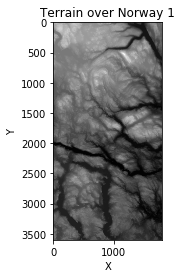

In [7]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
terrain2 = terrain1[:3600, :1800]  #makes it easier to make array smaller
terrain4 = (terrain2 - np.mean(terrain2)*np.ones(terrain2.shape))/(np.std(terrain2))

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

The terrain data is the height, which is basically the z-function. X and Y are the points from 0-1801 and 0-3601 respectively. Making these vectors and then creating a meshgrid for x and y gives the points. 

In [8]:
#x = np.arange(0, 1800)
#y = np.arange(0, 3600)

x = np.linspace(0, 1, 1800) 
y = np.linspace(0, 1, 3600)

xx, yy = np.meshgrid(x,y)

k = 9 # factor by which each axis will get shorter --> amount of points decreases by k^2
xlr = rebin(xx, (3600//k, 1800//k))
ylr = rebin(yy, (3600//k, 1800//k))
terrain3 = rebin(terrain4, (3600//k, 1800//k))


#Transform from matrices to vectors 
x_1 = np.ravel(xlr)
y_1 = np.ravel(ylr)
z_1 = np.ravel(terrain3)

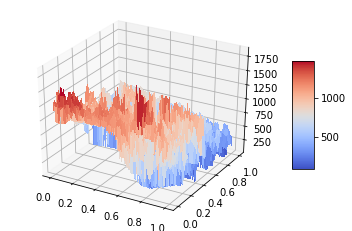

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx,yy,terrain2, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

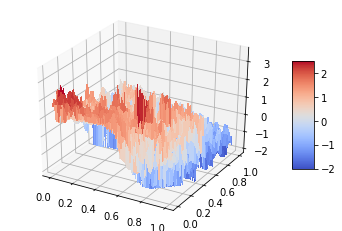

In [10]:
# plot the smaller data
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xlr,ylr,terrain3, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [11]:
X = CreateDesignMatrix_X(x_1, y_1, 5)
beta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde1 = X @ beta

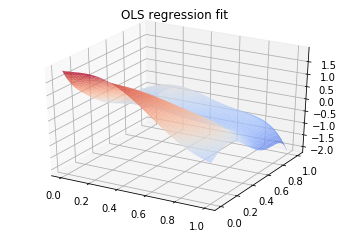

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
#ax1.set_zlim3d(-0.2, 1.2)

ax1.plot_surface(xlr, ylr, ztilde1.reshape(xlr.shape), alpha=0.8, cmap=cm.coolwarm)

#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title(f'OLS regression fit')
plt.show()

# 1. OLS regression

Splitting the data into train and test data 

In [13]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)

Instead of 'inv' you could use 'pinv', which uses the SVD 'behind the scenes', if the matrix is not invertible it will use the SVD, if it is it will use normal inversion. However, here pinv gives really bad R2 scores, but it does make the MSE score much lower... 

In [14]:
X = CreateDesignMatrix_X(x_1, y_1, 5)
Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)
beta = np.linalg.pinv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(ztrain)
ztilde = Xtrain @ beta
zpred = Xtest @ beta

In [15]:
print('MSE training:', MSE(ztrain, ztilde))
print('MSE test', MSE(ztest, zpred))

MSE training: 0.45856217986995607
MSE test 0.45526484986744037


The MSE scores are crazy high because the data is not normalized. However, normalizing is not necessary for this project. 

In [16]:
print('R2 training:', R2(ztrain, ztilde))
print('R2 test', R2(ztest, zpred))

R2 training: 0.5376047825292172
R2 test 0.5486741167182536


### 1.1. K-Fold cross-validation for OLS

In [17]:
r, _, m, _ = cross_validation(X, z_1, 10)
print("R2-Score_OLS: %0.3f (+/- %0.3f)" % (r.mean(), r.std() * 2))
print("MSE-Score_OLS: %0.5f (+/- %0.5f)" % (m.mean(), m.std() * 2))

R2-Score_OLS: 0.540 (+/- 0.012)
MSE-Score_OLS: 0.45811 (+/- 0.01621)


### Complexity of the model vs. the MSE score

In [18]:
maxdegree = 13
number_of_splits = 5

mse_scores = np.zeros(maxdegree)
mse_train_scores = np.zeros(maxdegree)

for degree in range(1, maxdegree + 1):
    X2 = CreateDesignMatrix_X(x_1, y_1, degree)
    _, _, m, r = cross_validation(X2, z_1, number_of_splits)
    mse_train_scores[degree - 1] = r.mean()
    mse_scores[degree - 1] = m.mean()

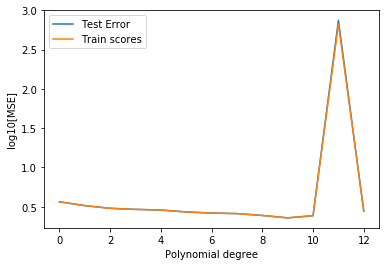

In [19]:
plt.plot(np.arange(maxdegree), mse_scores, label='Test Error')
plt.plot(np.arange(maxdegree), mse_train_scores, label='Train scores')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

In [20]:
k = 5
maxdegree = 13

r2_test = np.zeros((k, maxdegree))
r2_train = np.zeros((k, maxdegree))
mse_test = np.zeros((k, maxdegree))
mse_train = np.zeros((k, maxdegree))

for j in range(1, maxdegree + 1):
    x = CreateDesignMatrix_X(x_1, y_1, j)
    y = z_1
    n = len(x)

    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]

    
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        model = skl.LinearRegression()
        model = model.fit(x_train[:, 1:], y_train)
        ypredict = model.predict(x_test[:, 1:])
        ytilde = model.predict(x_train[:, 1:])

        r2_test[i, j-1] = R2(y_test, ypredict)
        r2_train[i, j-1] = R2(y_train, ytilde)
        mse_test[i, j-1] = MSE(y_test, ypredict)
        mse_train[i, j-1] = MSE(y_train, ytilde)

r2_test = np.mean(r2_test, axis = 0)
r2_train = np.mean(r2_train, axis = 0)
mse_test = np.mean(mse_test, axis = 0)
mse_train = np.mean(mse_train, axis = 0)

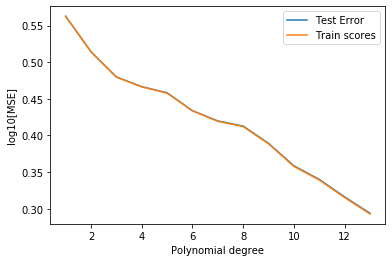

In [21]:
plt.plot(np.arange(maxdegree)+1, mse_test, label='Test Error')
plt.plot(np.arange(maxdegree)+1, mse_train, label='Train scores')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

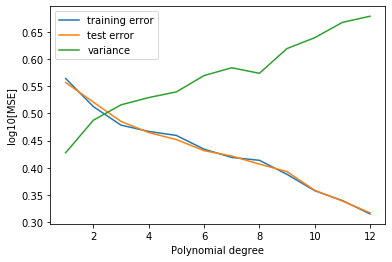

In [22]:
maxdegree = 12
train_mse = np.zeros(maxdegree)
test_mse = np.zeros(maxdegree)
variance = np.zeros(maxdegree)

for degree in range(1, maxdegree+1):
    X1 = CreateDesignMatrix_X(x_1, y_1, n=degree)
    X1_train, X1_test, z1_train, z1_test = train_test_split(X1, z_1, test_size=0.2)
    
    model = LinearRegression().fit(X1_train[:, 1:], z1_train)
    zpredict1 = model.predict(X1_test[:, 1:])
    ztilde1 = model.predict(X1_train[:, 1:])

    
    test_mse[degree - 1] = MSE(z1_test, zpredict1)
    train_mse[degree - 1] = MSE(z1_train, ztilde1)
    variance[degree - 1] = np.var(zpredict1)

plt.plot(np.arange(maxdegree) + 1, train_mse, label='training error')
plt.plot(np.arange(maxdegree) + 1, test_mse, label='test error')
plt.plot(np.arange(maxdegree) + 1, variance, label='variance')

plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

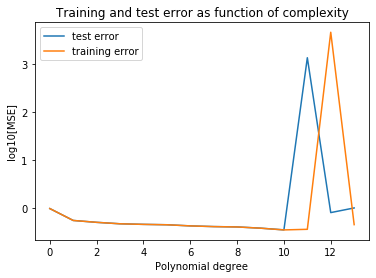

In [23]:
maxdegree = 14
k = 5
test_mse = np.zeros(maxdegree)
train_mse = np.zeros(maxdegree)

for degree in range(maxdegree):
    X1 = CreateDesignMatrix_X(x_1, y_1, n=degree)
    train_mse[degree] = np.mean(cross_validation(X1, z_1, k)[3])
    test_mse[degree] = np.mean(cross_validation(X1, z_1, k)[2])

plt.plot(np.arange(maxdegree), np.log10(test_mse), label='test error')
plt.plot(np.arange(maxdegree), np.log10(train_mse), label='training error')

plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.title('Training and test error as function of complexity')

plt.legend()
plt.show()

In [24]:
kfold = KFold(n_splits = k, shuffle=True)

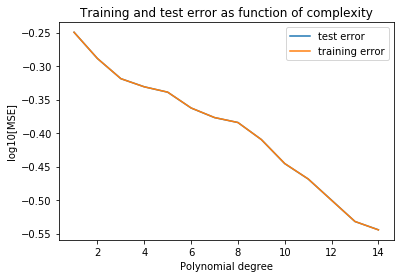

In [25]:
maxdegree = 14
k = 5
test_mse = np.zeros(maxdegree)
train_mse = np.zeros(maxdegree)

for degree in range(1, maxdegree + 1):
    X1 = CreateDesignMatrix_X(x_1, y_1, n=degree)
    train_mse[degree - 1] = -np.mean(cross_val_score(LinearRegression(), X1[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold))
    test_mse[degree - 1] = -np.mean(cross_val_score(LinearRegression(), X1[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold))

plt.plot(np.arange(maxdegree) + 1, np.log10(test_mse), label='test error')
plt.plot(np.arange(maxdegree) + 1, np.log10(train_mse), label='training error')

plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.title('Training and test error as function of complexity')

plt.legend()
plt.show()

# 2. Ridge regression

Let's first see which $\lambda$ is best, so that we know which value of lambda to use for the ridge regression

In [26]:
from sklearn.model_selection import train_test_split
X = CreateDesignMatrix_X(x_1, y_1, 5)
Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)

In [27]:
_lambda = 1e1
beta = np.linalg.inv(Xtrain.T.dot(Xtrain)+_lambda*np.eye(len(Xtrain[0]))).dot(Xtrain.T).dot(ztrain)
ztilde = Xtrain @ beta
zpred = Xtest @ beta
print('MSE training:', MSE(ztrain, ztilde))
print('MSE test', MSE(ztest, zpred))
print('R2 training:', R2(ztrain, ztilde))
print('R2 test', R2(ztest, zpred))

MSE training: 0.4827103717089095
MSE test 0.4821896108879834
R2 training: 0.5166756384982103
R2 test 0.5082964282096456


In [28]:
model = Ridge(alpha = _lambda)
model = model.fit(Xtrain[:, 1:], ztrain)
zpred = model.predict(Xtest[:, 1:])
ztilde = model.predict(Xtrain[:, 1:])
print('MSE training:', MSE(ztrain, ztilde))
print('MSE test', MSE(ztest, zpred))
print('R2 training:', R2(ztrain, ztilde))
print('R2 test', R2(ztest, zpred))

MSE training: 0.4826960039923929
MSE test 0.4821687938162508
R2 training: 0.5166899918669915
R2 test 0.5083165275818237


In [29]:
k = 5
nlambdas = 50
lambdas = np.logspace(-7, 1, nlambdas)

mse_ridge = np.zeros(nlambdas)

X = CreateDesignMatrix_X(x_1, y_1, 5)

for i in range(nlambdas):
    mse_ridge[i] = -np.mean(cross_val_score(Ridge(alpha = lambdas[i]), X[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold))

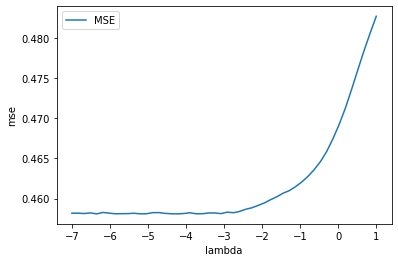

In [30]:
plt.figure()
plt.plot(np.log10(lambdas), mse_ridge ,label='MSE')
plt.xlabel('lambda')
plt.ylabel('mse')
plt.legend()
plt.show()

In [31]:
lambdas = np.logspace(-7, 1, nlambdas)
param_grid = {'alpha': lambdas}

ridge = Ridge()

ridge_regressor = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=kfold)
ridge_regressor.fit(X, z_1)
#ridge_regressor.fit(X[:, 1:], z_1)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 5.9636233165946365e-05}
-0.458189740545485


In [32]:
nlambdas = 7
maxdegree = 12
lambdas = np.logspace(-5, 1, nlambdas)

mse_ridge = np.zeros((maxdegree, nlambdas+1))

for j in range(1, maxdegree+1):
    X = CreateDesignMatrix_X(x_1, y_1, j)
    Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)
    mse_ridge[j-1, nlambdas] = MSE(LinearRegression().fit(Xtrain[:, 1:], ztrain).predict(Xtest[:, 1:]), ztest)
    for i in range(nlambdas):
        model = Ridge(alpha = lambdas[i]).fit(Xtrain[:, 1:], ztrain)
        zpred = model.predict(Xtest[:, 1:])
        mse_ridge[j-1, i] = MSE(zpred, ztest)

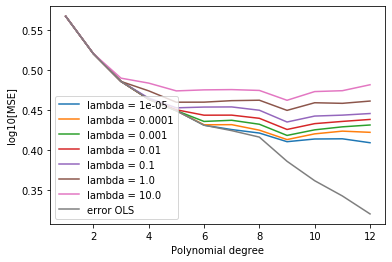

In [33]:
for i in range(nlambdas):
    plt.plot(np.arange(maxdegree)+1, mse_ridge[:,i], label='lambda = {}'.format(lambdas[i]))

plt.plot(np.arange(maxdegree)+1, mse_ridge[:, nlambdas], label='error OLS')    #the matrix probably gets near-singular for a higher complexity, which is why the OLS error goes up real fast. we can try the SVD
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show() 

# 3. Lasso regression

In [34]:
X = CreateDesignMatrix_X(x_1, y_1, 5)
Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)
model = Lasso(alpha = _lambda)
model = model.fit(Xtrain[:, 1:], ztrain)
zpred = model.predict(Xtest[:, 1:])
ztilde = model.predict(Xtrain[:, 1:])
print('MSE training:', MSE(ztrain, ztilde))
print('MSE test', MSE(ztest, zpred))
print('R2 training:', R2(ztrain, ztilde))
print('R2 test', R2(ztest, zpred))

MSE training: 0.9933354546629066
MSE test 1.0022327617446132
R2 training: 0.0
R2 test 0.0


In [35]:
#k = 5
#nlambdas = 50
#lambdas = np.logspace(-7, 1, nlambdas)

#mse_lasso = np.zeros(nlambdas)

#X = CreateDesignMatrix_X(x_1, y_1, 5)

#for i in range(nlambdas):
#    mse_lasso[i] = -np.mean(cross_val_score(Lasso(alpha = lambdas[i]), X[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold))

In [36]:
nlambdas = 30
lambdas = np.logspace(-5, 1, nlambdas)

mse_lasso = np.zeros(nlambdas)

X = CreateDesignMatrix_X(x_1, y_1, 5)
Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)

for i in range(nlambdas):
    model = Lasso(alpha = lambdas[i]).fit(Xtrain[:, 1:], ztrain)
    zpred = model.predict(Xtest[:, 1:])
    mse_lasso[i] = MSE(zpred, ztest)

/home/torben/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13577.57491628029, tolerance: 6.377462900401279
  positive)
/home/torben/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12699.01838171267, tolerance: 6.377462900401279
  positive)
/home/torben/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11358.880469981614, tolerance: 6.377462900401279
  positive)
/home/torben/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

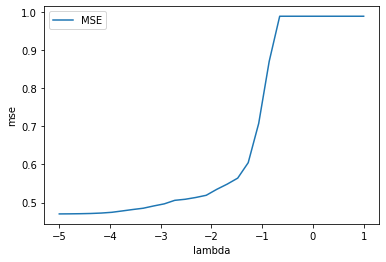

In [37]:
plt.figure()
plt.plot(np.log10(lambdas), mse_lasso ,label='MSE')
plt.xlabel('lambda')
plt.ylabel('mse')
plt.legend()
plt.show()

In [41]:
nlambdas = 7
maxdegree = 12
lambdas = np.logspace(-5, 1, nlambdas)

mse_lasso = np.zeros((maxdegree, nlambdas+1))

for j in range(1, maxdegree+1):
    X = CreateDesignMatrix_X(x_1, y_1, j)
    Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)
    mse_lasso[j-1, nlambdas] = MSE(LinearRegression().fit(Xtrain[:, 1:], ztrain).predict(Xtest[:, 1:]), ztest)
    for i in range(nlambdas):
        model = Lasso(alpha = lambdas[i]).fit(Xtrain[:, 1:], ztrain)
        zpred = model.predict(Xtest[:, 1:])
        mse_lasso[j-1, i] = MSE(zpred, ztest)

/home/torben/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11537.581755987027, tolerance: 6.375153231871218
  positive)
/home/torben/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.6271146434083, tolerance: 6.375153231871218
  positive)
/home/torben/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12995.005459049109, tolerance: 6.35744555529965
  positive)
/home/torben/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

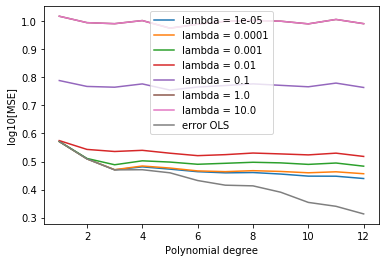

In [42]:
for i in range(nlambdas):
    plt.plot(np.arange(maxdegree)+1, mse_lasso[:,i], label='lambda = {}'.format(lambdas[i]))

plt.plot(np.arange(maxdegree)+1, mse_lasso[:, nlambdas], label='error OLS')    #the matrix probably gets near-singular for a higher complexity, which is why the OLS error goes up real fast. we can try the SVD
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show() 

In [47]:
nlambdas = 50
lambdas_lasso = np.logspace(-7, 1, nlambdas)
param_grid_lasso = {'alpha': lambdas_lasso}

lasso = skl.Lasso(precompute = True, tol = 100, max_iter = 10e3)

lasso_regressor = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=5)
X = CreateDesignMatrix_X(x_1, y_1, 10)
lasso_regressor.fit(X[:, 1:], z_1)

print(lasso_regressor.best_params_)
print(-lasso_regressor.best_score_)
Xtrain, Xtest, ztrain, ztest = train_test_split(X, z_1, test_size=0.2)
model = Lasso(alpha = lasso_regressor.best_params_['alpha'])
model = model.fit(Xtrain[:, 1:], ztrain)
zpred = model.predict(Xtest[:, 1:])
print(MSE(zpred, ztest))

{'alpha': 0.0008286427728546842}
0.6163226855954035
0.4858277893154741


/home/torben/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.17916280047211, tolerance: 6.36554217515676
  positive)
